# Bayesian Parameter Identification
## Setup Model and FEM (according to E2)

In [95]:
# For better printing within jupyter cells (otherwise only the last variable is printed)
import IPython; IPython.core.interactiveshell.InteractiveShell.ast_node_interactivity = "all"

# Standard python libraries
import os

# General computing libraries
import math
import numpy
import scipy.optimize

# Meshing libraries
import gmsh
import meshio

# Finite element libraries
import dolfin as df
df.parameters["allow_extrapolation"] = True

# Plotting libraries
import matplotlib.pyplot as plt

# VTK and visualization
import itkwidgets
import vtk

# Tracking libraries
import dolfin_warp as dwarp

# MEC581 python library
import LIB581

In [96]:
def create_mesh(
        X0,                   # first component of the center of the tube, in mm
        Y0,                   # second component of the center of the tube, in mm
        Ri,                   # internal radius of the tube, in mm
        Re,                   # external radius of the tube, in mm
        l,                    # characteristic size of the mesh cells, in mm
        mesh_folder="Project",     # folder the mesh file
        mesh_basename="mesh", # basename of the mesh file
        verbose=False):       # print or not the GMSH output

    ## Initialization of GMSH
    gmsh.initialize()
    if not (verbose): gmsh.option.setNumber("General.Terminal",0)
    gmsh.clear()

    ## Geometry
    factory = gmsh.model.geo

    # Points
    p0 = factory.addPoint(X0, Y0, 0, l) ### YOUR CODE HERE ###
    # 4 points on the inner loop
    p1 = factory.addPoint(X0+Ri, Y0, 0, l)
    p2 = factory.addPoint(X0, Y0+Ri, 0, l)
    p3 = factory.addPoint(X0-Ri, Y0, 0, l)
    p4 = factory.addPoint(X0, Y0-Ri, 0, l)
    # 4 points on the outer loop
    p5 = factory.addPoint(X0+Re, Y0, 0, l)
    p6 = factory.addPoint(X0, Y0+Re, 0, l)
    p7 = factory.addPoint(X0-Re, Y0, 0, l)
    p8 = factory.addPoint(X0, Y0-Re, 0, l)

    # Curves
    # 4 curves for the inner loop
    l11 = factory.addCircleArc(p1, p0, p2) ### YOUR CODE HERE ###
    l12 = factory.addCircleArc(p2, p0, p3)
    l13 = factory.addCircleArc(p3, p0, p4)
    l14 = factory.addCircleArc(p4, p0, p1)
    # 4 curves for the outer loop
    l21 = factory.addCircleArc(p5, p0, p6)
    l22 = factory.addCircleArc(p6, p0, p7)
    l23 = factory.addCircleArc(p7, p0, p8)
    l24 = factory.addCircleArc(p8, p0, p5)
    

    # Curve loop
    cl = factory.addCurveLoop([l11, l12, l13, l14, l21, l22, l23, l24])### YOUR CODE HERE ###

    # Surface
    s = factory.addPlaneSurface([cl]) ### YOUR CODE HERE ###

    # Synchronization, cf., e.g., https://gitlab.onelab.info/gmsh/gmsh/-/blob/master/tutorial/python/t1.py
    factory.synchronize()

    # In order to only save nodes and elements of the final surface
    # (i.e., not the construction points like the circle center,
    # nor the line elements of the line entities—remember that 
    # unstructured meshers will first mesh the curves, then the
    # surfaces and the volumes, cf. MEC552 L5.2), we declare it as a
    # "physical" surface.
    ps = gmsh.model.addPhysicalGroup(dim=2, tags=[s])

    ## Mesh
    mesh_gmsh = gmsh.model.mesh

    # Mesh generation
    mesh_gmsh.generate(dim=2)

    # In order to visualize the mesh and perform finite element computation using
    # FEniCS, we need to convert the mesh from the GMSH format to the VTK & FEniCS
    # formats. Since there is no direct converter between these formats, we do
    # that here by writing the mesh to the disc in VTK format using GMSH, which
    # we can then read in various formats later on.
    if not os.path.exists(mesh_folder): os.mkdir(mesh_folder)
    gmsh.write(mesh_folder+"/"+mesh_basename+".vtk")

    # Finalization of GMSH
    gmsh.finalize()

    # To convert the mesh from vtk to dolfin format,
    # we use [meshio](https://github.com/nschloe/meshio).
    mesh_meshio = meshio.read(mesh_folder+"/"+mesh_basename+".vtk")

    # For 2D meshes, we need to remove the third component of points,
    # otherwise FEniCS believes it is 3D…
    mesh_meshio.points = mesh_meshio.points[:, :2]

    # We write the mesh in XDMF format.
    meshio.write(mesh_folder+"/"+mesh_basename+".xdmf", mesh_meshio)

    # Finaly we can read the mesh in FEniCS format.
    mesh = df.Mesh()
    df.XDMFFile(mesh_folder+"/"+mesh_basename+".xdmf").read(mesh)

    return mesh

# Now we test the function.
mesh = create_mesh(X0=0.5, Y0=0.5, Ri=0.2, Re=0.3, l=0.1/5, verbose=1)

# We check some mesh informations.
print ("geometric_dimension:", mesh.geometric_dimension())
print ("num_vertices:", mesh.num_vertices())
print ("num_cells:", mesh.num_cells())

# We can define "measures", which allow to integrate expressions over (part of) the mesh.
dV = df.Measure("dx", domain=mesh) # "dx" means over the domain itself
mesh_V0 = df.assemble(df.Constant(1.) * dV)
print ("mesh_V0", mesh_V0)

# We visualize the mesh, by writing it to disk in VTK format, reading it,
# and using [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets).
LIB581.write_VTU_file("Project/mesh", mesh)
mesh_vtk = LIB581.read_VTU_file("Project/mesh")
itkwidgets.view(geometries=mesh_vtk)

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Starting subloop 1 in curve loop 1 (are you sure about this?)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Circle)
Info    : [ 30%] Meshing curve 3 (Circle)
Info    : [ 40%] Meshing curve 4 (Circle)
Info    : [ 50%] Meshing curve 5 (Circle)
Info    : [ 70%] Meshing curve 6 (Circle)
Info    : [ 80%] Meshing curve 7 (Circle)
Info    : [ 90%] Meshing curve 8 (Circle)
Info    : Done meshing 1D (Wall 0.0014055s, CPU 0.001522s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0157305s, CPU 0.016233s)
Info    : 575 nodes 1157 elements
Info    : Writing 'Project/mesh.vtk'...
Info    : Done writing 'Project/mesh.vtk'
geometric_dimension: 2
num_vertices: 574
num_cells: 988
mesh_V0 0.1570795786523808


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [97]:
def create_boundaries(
        X0, Y0, Ri, Re,
        mesh):

    # We create a "MeshFunction",
    # which will allow us to assign an id to each edge of the mesh.

    boundaries_mf = df.MeshFunction(
        value_type="size_t", # size_t is like unisgned int, but more robust with respect to architecture and os
        mesh=mesh,
        dim=1) # 0 for nodes, 1 for edges, 2 for faces, etc.

    # We initialize it to zero.

    boundaries_mf.set_all(0)

    # Now we define geometrical subdomains.

    Si_sd = df.AutoSubDomain(
        lambda x, on_boundary:
            on_boundary and\
            df.near((x[0]-X0)**2+(x[1]-Y0)**2, Ri**2, eps=1e-3))### YOUR CODE HERE ###

    Se_sd = df.AutoSubDomain(
        lambda x, on_boundary:
            on_boundary and\
            df.near((x[0]-X0)**2+(x[1]-Y0)**2, Re**2, eps=1e-3))### YOUR CODE HERE ###

    # And we use the subdomains to mark the different parts of the mesh.

    Si_id = 1; Si_sd.mark(boundaries_mf, Si_id)
    Se_id = 2; Se_sd.mark(boundaries_mf, Se_id)

    return boundaries_mf

# Now we test the function.
X0 = 0.5; Y0 = 0.5; Ri = 0.2; Re = 0.3; l=0.1/3
mesh = create_mesh(X0=X0, Y0=Y0, Ri=Ri, Re=Re, l=l)
boundaries_mf = create_boundaries(X0=X0, Y0=Y0, Ri=Ri, Re=Re, mesh=mesh)

# We can define "measures", which allow to integrate expressions over (part of) the mesh boundary.
dS = df.Measure("ds", domain=mesh, subdomain_data=boundaries_mf) # "ds" means over the domain boundary
mesh_S0 = df.assemble(df.Constant(1) * dS)
print ("mesh_S0", mesh_S0)
Si_id = 1; mesh_Si0 = df.assemble(df.Constant(1) * dS(Si_id))
print ("mesh_Si0", mesh_Si0)
Se_id = 2; mesh_Se0 = df.assemble(df.Constant(1) * dS(Se_id))
print ("mesh_Se0", mesh_Se0)

# We visualize the boundaries.
LIB581.write_VTU_file("Project/boundaries", boundaries_mf)
boundaries_vtk = LIB581.read_VTU_file("Project/boundaries")
itkwidgets.view(geometries=boundaries_vtk)

mesh_S0 3.1394399563914983
mesh_Si0 1.255345531645519
mesh_Se0 1.8840944247459779


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [98]:
# We can define the finite element function space of the model,
# for instance here with second order Lagrange polynomials,

U_fs = df.VectorFunctionSpace(mesh, "Lagrange", degree=2)
U_fs.dim()

# as well as the function into which we will store the solution.
# Dolfin functions are very convenient objects, which contain both
# a symbolic representation of the finite element approximation
# (i.e., the linear combination of the shape functions, which we 
# can derive, integrate, etc.) and the array containing the degrees
# of freedom (all the linear algebra is handled by [PETSc](https://www.mcs.anl.gov/petsc),
# which has a pretty ugly website but is one of the most efficient
# open source libraries for linear algebra, though we can also
# manipulate them as numpy arrays for convenience).

U = df.Function(U_fs, name="U")
U
df.grad(U)
U.vector()
U.vector().get_local()

# We can also define "test" and "trial" functions, which are abstract objects
# used to define linear and bilinear variational forms: a linear form 
# must be linear with respect to the "test" function (which is the U^*
# of the equations); a bilinear form must be linear in both the "test"
# function and "trial" function (which is the U of the equations in the 
# linear setting, the ΔU of the equations in the nonlinear setting, i.e.,
# it is the unknown of the linear problem).

U_test  = df.TestFunction(U_fs)
U_trial = df.TrialFunction(U_fs)

1816

Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 26155), VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2)), 26171)

Grad(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 26155), VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2)), 26171))

array([0., 0., 0., ..., 0., 0., 0.])

In [99]:
def create_bcs(
        X0, Y0, Ri, Re, U_fs):

    x1 = [X0+Ri, Y0]
    x1_sd = df.AutoSubDomain(
        lambda x, on_boundary: df.near(x[0], x1[0], eps=1e-3) and df.near(x[1], x1[1], eps=1e-3)) #define the subdomains as the 3 points
    x2 = [X0, Y0+Ri]
    x2_sd = df.AutoSubDomain(
        lambda x, on_boundary: df.near(x[0], x2[0], eps=1e-3) and df.near(x[1], x2[1], eps=1e-3))
    x3 = [X0-Ri, Y0]
    x3_sd = df.AutoSubDomain(
        lambda x, on_boundary: df.near(x[0], x3[0], eps=1e-3) and df.near(x[1], x3[1], eps=1e-3))

    bc1 = df.DirichletBC(U_fs.sub(1), 0, x1_sd, "pointwise") # Block first y translation DoF
    bc2 = df.DirichletBC(U_fs.sub(0), 0, x2_sd, "pointwise") # Block first x translation DoF
    bc3 = df.DirichletBC(U_fs.sub(1), 0, x3_sd, "pointwise") # Block translation DoF through second y translation block
    bcs = [bc1, bc2, bc3]

    return bcs

In [100]:
def create_mesh_boundaries_bcs_solution(
        X0, Y0, Ri, Re, l, degree):

    mesh = create_mesh(X0=X0, Y0=Y0, Ri=Ri, Re=Re, l=l)
    boundaries_mf = create_boundaries(X0=X0, Y0=Y0, Ri=Ri, Re=Re, mesh=mesh)
    U_fs = df.VectorFunctionSpace(mesh, "Lagrange", degree=degree)
    bcs = create_bcs(X0=X0, Y0=Y0, Ri=Ri, Re=Re, U_fs=U_fs)
    U = df.Function(U_fs, name="U")

    return mesh, boundaries_mf, bcs, U

In [101]:
def solve_nonlinear_model(mesh, boundaries_mf, bcs, U, Y, nu, P, init_U=None):

    # Kinematics
    # (We define C as a dolfin.variable,
    #  and derive all quantities (including J!) from it,
    #  such that we can later derive the energy with respect to C.)

    I    = df.Identity(2) ### YOUR CODE HERE ### # Identity
    F    = I + df.grad(U) ### YOUR CODE HERE ### # Deformation gradient
    C    = F.T*F ### YOUR CODE HERE ### # Right Cauchy-Green dilatation tensor
    C    = df.variable(C)
    IC   = df.tr(C) ### YOUR CODE HERE ### # First invariant
    IIIC = df.det(C) ### YOUR CODE HERE ### # Third invariant
    J    = df.sqrt(IIIC) ### YOUR CODE HERE ### # Volume ratio
    E    = 0.5*(C - I) ### YOUR CODE HERE ### # Green-Lagrange strain

    # Virtual work of internal forces
    # (We redefine the parameters as dolfin.Constant,
    #  such that dolfin does not recompile the variational forms
    #  for each value of the parameters.)

    Y     = df.Constant(Y)       # Young modulus (E already used for Green-Lagrange strain)
    nu    = df.Constant(nu)      # Poisson ratio
    lmbda = (Y*nu) / ((1.0 + nu)*(1.0 - 2.0*nu)) ### YOUR CODE HERE ### # Lamé constant (plane strain)
    mu    = Y/(2.0*(1.0 + nu)) ### YOUR CODE HERE ### # Lamé constant

    W  = 0.25*lmbda*(J**2 - 1.0 - 2.0*df.ln(J)) ### YOUR CODE HERE ### # Ogden-Ciarlet-Geymonat bulk energy
    W += 0.5*mu*(IC - 3.0 - 2.0*df.ln(J)) ### YOUR CODE HERE ### # Neo-Hookean energy (plane strain)
    Sigma = df.diff(W, C) ### YOUR CODE HERE ###

    U_test = df.TestFunction(U.function_space())
    delta_E = 0.5*(df.grad(U_test).T*F + F.T*df.grad(U_test)) ### YOUR CODE HERE ###

    dV = df.Measure("dx", domain=mesh)

    Wint = df.inner(Sigma, delta_E)*dV ### YOUR CODE HERE ###

    # Virtual work of external forces
    # (We redefine the parameters as dolfin.Constant,
    #  such that dolfin does not recompile the variational forms
    #  for each value of the parameters.)

    P = df.Constant(P)
    N = df.FacetNormal(mesh)
    dS = df.Measure("ds", domain=mesh, subdomain_data=boundaries_mf)
    Si_id = 1

    Wext = -df.dot(P*N, U_test)*dS(Si_id) ### YOUR CODE HERE ###

    # Nonlinear solver
    # (Note that for nonlinear problems solved using the Newton method,
    #  as is the case here, the initial solution of the iterations has a
    #  strong impact on convergence. Thus, we put an additional optional
    #  parameter to the function: if `init_U=True` (the default), the
    #  solution is initialized at 0 before starting the iterations;
    #  conversely, if `init_U=False`, the solution is not initialized,
    #  so the iterations start from the current displacement fields.

    res = Wint - Wext ### YOUR CODE HERE ###

    U_trial = df.TrialFunction(U.function_space())
    jac = df.derivative(res, U, U_trial) ### YOUR CODE HERE ###
    
    if (init_U): U.vector().zero()

    df.solve(res == 0, U, bcs, J=jac) ### YOUR CODE HERE ###

In [102]:
mesh, boundaries_mf, bcs, U = create_mesh_boundaries_bcs_solution(X0=0.5, Y0=0.5, Ri=0.2, Re=0.3, l=0.1/5, degree=2)
solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U, Y=10., nu=0.3, P=+1.)

# To visualize the solution, we save it into the VTK format.
# (The displacement field is applied onto the mesh, which then represents the deformed configuration;
#  you can change the multiplicative factor of the displacement field to better see the deformation.)
LIB581.write_VTU_file("Project/model", U)
LIB581.Viewer(meshes="Project/model.vtu").view()

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 1.323e-01 (tol = 1.000e-10) r (rel) = 1.131e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 3.449e-03 (tol = 1.000e-10) r (rel) = 2.947e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 3.512e-05 (tol = 1.000e-10) r (rel) = 3.001e-04 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 4.475e-10 (tol = 1.000e-10) r (rel) = 3.825e-09 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 9.069e-15 (tol = 1.000e-10) r (rel) = 7.751e-14 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.


## Bayesian Identification
### Set-Up

In [103]:
# Setup the simulation (geometry, mesh, boundaries, BCs, function space)
X0, Y0, Ri, Re, l = 0.5, 0.5, 0.2, 0.3, 0.1/5
mesh, boundaries_mf, bcs, U = create_mesh_boundaries_bcs_solution(
    X0=X0, Y0=Y0, Ri=Ri, Re=Re, l=l, degree=2)

# Define “true” parameters
true_Y = 10.0
nu = 0.3
P_obs = 1.0

# Solve the forward (nonlinear) model with the true Young modulus
solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf, bcs=bcs, U=U,
                      Y=true_Y, nu=nu, P=P_obs)

# Save the result as the observed displacement (deep copy the field)
U_obs = df.Function(U.function_space())
U_obs.assign(U)


  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 1.323e-01 (tol = 1.000e-10) r (rel) = 1.131e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 3.449e-03 (tol = 1.000e-10) r (rel) = 2.947e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 3.512e-05 (tol = 1.000e-10) r (rel) = 3.001e-04 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 4.475e-10 (tol = 1.000e-10) r (rel) = 3.825e-09 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 9.069e-15 (tol = 1.000e-10) r (rel) = 7.751e-14 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.


### Define a distance mesaure

In [104]:
dV = df.Measure("dx", domain=mesh)
def compute_distance(U1, U2):
    """Compute the L2 error between two displacement fields."""
    error_sq = df.assemble(df.inner(U1 - U2, U1 - U2) * dV)
    return np.sqrt(error_sq)

### Setup ABC Rejection Algorithm

In [ ]:
# Prior for the Young modulus: Uniform over [Y_min, Y_max]
Y_min, Y_max = 5.0, 15.0

In [105]:
# Number of trials and acceptance threshold (tune epsilon as needed)
N_trials = 250
epsilon = 0.01  # adjust this threshold to control the acceptance rate

accepted_Y = []
accepted_distances = []

for i in range(N_trials):
    # Sample Y from the uniform prior
    Y_sample = np.random.uniform(Y_min, Y_max)
    
    # Solve the forward model with the sampled Young modulus
    # Note: use init_U=True to reinitialize the displacement field at each iteration.
    solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf,
                           bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)
    
    # Compute the discrepancy between the current simulation and the observed data
    d = compute_distance(U, U_obs)
    
    # Accept the sample if the error is below the threshold epsilon
    if d < epsilon:
        accepted_Y.append(Y_sample)
        accepted_distances.append(d)
        print(f"Accepted {i}: Y_sample = {Y_sample:.3f}, distance = {d:.3f}")
    else:
        print(f"Rejected {i}: Y_sample = {Y_sample:.3f}, distance = {d:.3f}")

print("Number of accepted samples:", len(accepted_Y))


  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 2.220e-01 (tol = 1.000e-10) r (rel) = 1.897e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 7.317e-03 (tol = 1.000e-10) r (rel) = 6.254e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 1.375e-04 (tol = 1.000e-10) r (rel) = 1.175e-03 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 1.440e-08 (tol = 1.000e-10) r (rel) = 1.231e-07 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 1.128e-14 (tol = 1.000e-10) r (rel) = 9.636e-14 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.
Rejected 0: Y_sample = 7.383, distance = 0.024
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 8.300e-02 (tol = 1.000e-10) r (rel) = 7.094e-01 (tol = 1.000e-

Rejected 12: Y_sample = 7.932, distance = 0.018    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 1.945e-01 (tol = 1.000e-10) r (rel) = 1.663e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 5.378e-03 (tol = 1.000e-10) r (rel) = 4.597e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 9.473e-05 (tol = 1.000e-10) r (rel) = 8.096e-04 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 6.494e-09 (tol = 1.000e-10) r (rel) = 5.550e-08 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 1.169e-14 (tol = 1.000e-10) r (rel) = 9.990e-14 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.

  Solving nonlinear variational problem.Rejected 13: Y_sample = 13.454, distance = 0.016

    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 8.569e-02 (tol = 1.000e-10) r (rel) = 7.324e-01 (tol 

  Solving nonlinear variational problem.Rejected 24: Y_sample = 13.766, distance = 0.017

    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 8.302e-02 (tol = 1.000e-10) r (rel) = 7.096e-01 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 1.672e-03 (tol = 1.000e-10) r (rel) = 1.429e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 6.091e-06 (tol = 1.000e-10) r (rel) = 5.205e-05 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 7.966e-12 (tol = 1.000e-10) r (rel) = 6.808e-11 (tol = 1.000e-09)
    Newton solver finished in 4 iterations and 4 linear solver iterations.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 2.260e-01 (tol = 1.000e-10) r (rel) = 1.931e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 7.715e-03 (tol = 1.000e-10) r (rel) = 6.594e-02 (tol = 1.000

  Solving nonlinear variational problem.Rejected 36: Y_sample = 5.220, distance = 0.069
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 5.025e-01 (tol = 1.000e-10) r (rel) = 4.294e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 9.882e-02 (tol = 1.000e-10) r (rel) = 8.445e-01 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 3.363e-03 (tol = 1.000e-10) r (rel) = 2.875e-02 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 5.686e-06 (tol = 1.000e-10) r (rel) = 4.860e-05 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 2.205e-11 (tol = 1.000e-10) r (rel) = 1.885e-10 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 9.575e-02 (tol = 1.000e-10) r (rel) = 8.183e-01 (tol = 1.000e

Rejected 48: Y_sample = 6.601, distance = 0.036
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 5.082e-01 (tol = 1.000e-10) r (rel) = 4.343e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 1.016e-01 (tol = 1.000e-10) r (rel) = 8.681e-01 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 3.583e-03 (tol = 1.000e-10) r (rel) = 3.062e-02 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 5.827e-06 (tol = 1.000e-10) r (rel) = 4.980e-05 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 2.630e-11 (tol = 1.000e-10) r (rel) = 2.248e-10 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.
Rejected 49: Y_sample = 5.202, distance = 0.069
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 8.273e-02 (to

Rejected 62: Y_sample = 13.335, distance = 0.015    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 8.676e-02 (tol = 1.000e-10) r (rel) = 7.415e-01 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 1.814e-03 (tol = 1.000e-10) r (rel) = 1.551e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 7.370e-06 (tol = 1.000e-10) r (rel) = 6.299e-05 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 1.231e-11 (tol = 1.000e-10) r (rel) = 1.052e-10 (tol = 1.000e-09)
    Newton solver finished in 4 iterations and 4 linear solver iterations.

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 1.023e-01 (tol = 1.000e-10) r (rel) = 8.744e-01 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 2.410e-03 (tol = 1.000e-10) r (rel) = 2.060e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 1

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 9.398e-02 (tol = 1.000e-10) r (rel) = 8.032e-01 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 2.092e-03 (tol = 1.000e-10) r (rel) = 1.788e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 1.030e-05 (tol = 1.000e-10) r (rel) = 8.804e-05 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 2.643e-11 (tol = 1.000e-10) r (rel) = 2.259e-10 (tol = 1.000e-09)
    Newton solver finished in 4 iterations and 4 linear solver iterations.
Rejected 74: Y_sample = 12.596, distance = 0.013
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 3.557e-01 (tol = 1.000e-10) r (rel) = 3.040e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 3.720e-02 (tol = 1.000e-10) r (rel) = 3.180e-01 (tol = 1.000

  Solving nonlinear variational problem.
Rejected 86: Y_sample = 12.217, distance = 0.011
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 9.816e-02 (tol = 1.000e-10) r (rel) = 8.390e-01 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 2.252e-03 (tol = 1.000e-10) r (rel) = 1.925e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 1.227e-05 (tol = 1.000e-10) r (rel) = 1.049e-04 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 3.941e-11 (tol = 1.000e-10) r (rel) = 3.368e-10 (tol = 1.000e-09)
    Newton solver finished in 4 iterations and 4 linear solver iterations.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 7.420e-02 (tol = 1.000e-10) r (rel) = 6.341e-01 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 1.344e-03 (tol = 1.000e-10) r (rel) = 1.148e-02 (tol = 1.000

Rejected 99: Y_sample = 7.015, distance = 0.030
Accepted 100: Y_sample = 10.446, distance = 0.003
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 1.237e-01 (tol = 1.000e-10) r (rel) = 1.057e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 3.174e-03 (tol = 1.000e-10) r (rel) = 2.713e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 2.840e-05 (tol = 1.000e-10) r (rel) = 2.427e-04 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 2.708e-10 (tol = 1.000e-10) r (rel) = 2.315e-09 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 8.319e-15 (tol = 1.000e-10) r (rel) = 7.110e-14 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.
Rejected 101: Y_sample = 11.960, distance = 0.010  Solving nonlinear variational problem.

    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e

Accepted 111: Y_sample = 11.229, distance = 0.007
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 2.850e-01 (tol = 1.000e-10) r (rel) = 2.435e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 1.735e-02 (tol = 1.000e-10) r (rel) = 1.483e-01 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 2.941e-04 (tol = 1.000e-10) r (rel) = 2.514e-03 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 4.088e-08 (tol = 1.000e-10) r (rel) = 3.494e-07 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 1.237e-14 (tol = 1.000e-10) r (rel) = 1.057e-13 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.
Rejected 112: Y_sample = 6.520, distance = 0.038
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 2.865e-01 

  Solving nonlinear variational problem.Rejected 124: Y_sample = 7.941, distance = 0.018
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 1.942e-01 (tol = 1.000e-10) r (rel) = 1.659e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 5.360e-03 (tol = 1.000e-10) r (rel) = 4.581e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 9.427e-05 (tol = 1.000e-10) r (rel) = 8.057e-04 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 6.413e-09 (tol = 1.000e-10) r (rel) = 5.481e-08 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 1.163e-14 (tol = 1.000e-10) r (rel) = 9.944e-14 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 9.516e-02 (tol = 1.000e-10) r (rel) = 8.133e-01 (tol = 1.000

  Solving nonlinear variational problem.Rejected 136: Y_sample = 6.448, distance = 0.039
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 2.919e-01 (tol = 1.000e-10) r (rel) = 2.494e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 1.892e-02 (tol = 1.000e-10) r (rel) = 1.617e-01 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 3.107e-04 (tol = 1.000e-10) r (rel) = 2.656e-03 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 4.458e-08 (tol = 1.000e-10) r (rel) = 3.810e-07 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 1.269e-14 (tol = 1.000e-10) r (rel) = 1.085e-13 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.

  Solving nonlinear variational problem.
Rejected 137: Y_sample = 6.185, distance = 0.044
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 3.203e-01 (

Accepted 148: Y_sample = 9.306, distance = 0.005
Rejected 149: Y_sample = 12.968, distance = 0.014
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 9.020e-02 (tol = 1.000e-10) r (rel) = 7.709e-01 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 1.947e-03 (tol = 1.000e-10) r (rel) = 1.664e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 8.692e-06 (tol = 1.000e-10) r (rel) = 7.429e-05 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 1.794e-11 (tol = 1.000e-10) r (rel) = 1.533e-10 (tol = 1.000e-09)
    Newton solver finished in 4 iterations and 4 linear solver iterations.
  Solving nonlinear variational problem.
Rejected 150: Y_sample = 14.233, distance = 0.018    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 7.931e-02 (tol = 1.000e-10) r (rel) = 6.779e-01 (tol = 1.000e

  Solving nonlinear variational problem.Rejected 162: Y_sample = 7.787, distance = 0.019

    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 2.011e-01 (tol = 1.000e-10) r (rel) = 1.719e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 5.729e-03 (tol = 1.000e-10) r (rel) = 4.896e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 1.033e-04 (tol = 1.000e-10) r (rel) = 8.831e-04 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 8.048e-09 (tol = 1.000e-10) r (rel) = 6.878e-08 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 1.202e-14 (tol = 1.000e-10) r (rel) = 1.027e-13 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.
  Solving nonlinear variational problem.Accepted 163: Y_sample = 9.484, distance = 0.004

    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 1.439e-01 (

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 7.564e-02 (tol = 1.000e-10) r (rel) = 6.465e-01 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 1.396e-03 (tol = 1.000e-10) r (rel) = 1.193e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 4.008e-06 (tol = 1.000e-10) r (rel) = 3.426e-05 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 3.060e-12 (tol = 1.000e-10) r (rel) = 2.615e-11 (tol = 1.000e-09)
    Newton solver finished in 4 iterations and 4 linear solver iterations.
Rejected 174: Y_sample = 14.740, distance = 0.019
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 9.707e-02 (tol = 1.000e-10) r (rel) = 8.297e-01 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 2.211e-03 (tol = 1.000e-10) r (rel) = 1.889e-02 (tol = 1.00

Accepted 186: Y_sample = 10.986, distance = 0.006  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 1.147e-01 (tol = 1.000e-10) r (rel) = 9.801e-01 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 2.864e-03 (tol = 1.000e-10) r (rel) = 2.448e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 2.196e-05 (tol = 1.000e-10) r (rel) = 1.876e-04 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 1.491e-10 (tol = 1.000e-10) r (rel) = 1.275e-09 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 7.559e-15 (tol = 1.000e-10) r (rel) = 6.460e-14 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 1.304e-01 (tol = 1.000e-10) r (rel) = 1.115e+00 (tol = 1.00

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 2.097e-01 (tol = 1.000e-10) r (rel) = 1.792e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 6.290e-03 (tol = 1.000e-10) r (rel) = 5.376e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 1.160e-04 (tol = 1.000e-10) r (rel) = 9.918e-04 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 1.042e-08 (tol = 1.000e-10) r (rel) = 8.906e-08 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 1.182e-14 (tol = 1.000e-10) r (rel) = 1.010e-13 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.
Rejected 197: Y_sample = 7.611, distance = 0.021
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 2.536e-01 (tol = 1.000e-10) r (rel) = 2.167e+00 (tol = 1.000

  Solving nonlinear variational problem.
Rejected 209: Y_sample = 5.182, distance = 0.070
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 5.142e-01 (tol = 1.000e-10) r (rel) = 4.395e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 1.042e-01 (tol = 1.000e-10) r (rel) = 8.908e-01 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 3.422e-03 (tol = 1.000e-10) r (rel) = 2.925e-02 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 1.392e-05 (tol = 1.000e-10) r (rel) = 1.189e-04 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 1.275e-10 (tol = 1.000e-10) r (rel) = 1.090e-09 (tol = 1.000e-09)
    Newton iteration 6: r (abs) = 2.002e-14 (tol = 1.000e-10) r (rel) = 1.711e-13 (tol = 1.000e-09)
    Newton solver finished in 6 iterations and 6 linear solver iterations.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000

  Solving nonlinear variational problem.Rejected 221: Y_sample = 5.868, distance = 0.051

    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 3.632e-01 (tol = 1.000e-10) r (rel) = 3.104e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 3.975e-02 (tol = 1.000e-10) r (rel) = 3.398e-01 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 3.456e-04 (tol = 1.000e-10) r (rel) = 2.953e-03 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 1.114e-07 (tol = 1.000e-10) r (rel) = 9.524e-07 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 2.422e-14 (tol = 1.000e-10) r (rel) = 2.070e-13 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.
  Solving nonlinear variational problem.
Rejected 222: Y_sample = 5.090, distance = 0.073
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 5.453e-01 (

Rejected 232: Y_sample = 6.521, distance = 0.038
  Solving nonlinear variational problem.
Accepted 233: Y_sample = 9.996, distance = 0.000
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 1.324e-01 (tol = 1.000e-10) r (rel) = 1.132e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 3.451e-03 (tol = 1.000e-10) r (rel) = 2.950e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 3.519e-05 (tol = 1.000e-10) r (rel) = 3.007e-04 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 4.497e-10 (tol = 1.000e-10) r (rel) = 3.843e-09 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 9.054e-15 (tol = 1.000e-10) r (rel) = 7.738e-14 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.
  Solving nonlinear variational problem.
Rejected 234: Y_sample = 6.050, distance = 0.047    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-0

  Solving nonlinear variational problem.Accepted 246: Y_sample = 8.727, distance = 0.010

    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 1.649e-01 (tol = 1.000e-10) r (rel) = 1.409e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 4.340e-03 (tol = 1.000e-10) r (rel) = 3.709e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 6.355e-05 (tol = 1.000e-10) r (rel) = 5.431e-04 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 2.096e-09 (tol = 1.000e-10) r (rel) = 1.791e-08 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 1.106e-14 (tol = 1.000e-10) r (rel) = 9.451e-14 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.
  Solving nonlinear variational problem.Rejected 247: Y_sample = 5.228, distance = 0.069
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 5.000e-01 (t

### Analyse the approximate Posterior

(array([0.97807393, 0.48903697, 0.73355545, 0.        , 0.24451848,
        0.        , 0.24451848, 0.        , 0.73355545, 0.24451848,
        0.        , 0.24451848, 0.48903697, 0.48903697, 0.        ,
        0.        , 0.73355545, 0.24451848, 0.24451848, 0.        ,
        0.24451848, 0.24451848, 0.        , 0.73355545, 0.        ,
        0.        , 0.        , 0.24451848, 0.24451848, 0.24451848,
        0.73355545, 0.        , 0.48903697, 0.24451848, 0.48903697,
        0.48903697, 0.48903697, 0.48903697, 0.24451848, 0.48903697,
        0.24451848, 0.48903697, 0.73355545, 0.        , 0.24451848,
        0.        , 0.48903697, 0.73355545, 0.        , 0.73355545]),
 array([ 8.72572137,  8.78863938,  8.85155738,  8.91447539,  8.97739339,
         9.0403114 ,  9.10322941,  9.16614741,  9.22906542,  9.29198342,
         9.35490143,  9.41781944,  9.48073744,  9.54365545,  9.60657345,
         9.66949146,  9.73240947,  9.79532747,  9.85824548,  9.92116348,
         9.98408149, 10.04

Text(0.5, 0, "Young's modulus, Y")

Text(0, 0.5, 'Approximate posterior density')

Text(0.5, 1.0, "ABC Posterior Distribution for Young's Modulus")

(5.0, 15.0)

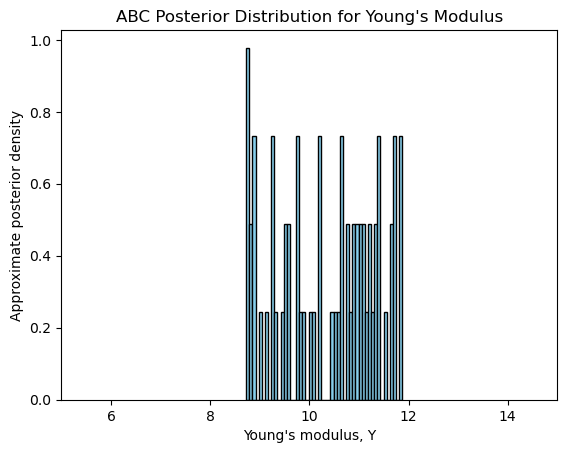

In [106]:
# Plot the histogram of accepted Young modulus values
plt.hist(accepted_Y, bins=50, density=True, color="skyblue", edgecolor="black")
plt.xlabel("Young's modulus, Y")
plt.ylabel("Approximate posterior density")
plt.title("ABC Posterior Distribution for Young's Modulus")
plt.xlim(Y_min, Y_max)
plt.show()

### Using the weighted si

In [108]:
# Number of samples to draw
N_trials = 100

# Small constant to avoid division by zero in weights
eps_w = 1e-3

# Lists to store samples and their weights
all_samples = []
all_weights = []

for i in range(N_trials):
    # Sample Y from the uniform prior
    Y_sample = np.random.uniform(Y_min, Y_max)
    
    # Solve the forward model with the sampled Young modulus.
    # Use init_U=True to reinitialize the displacement field.
    solve_nonlinear_model(mesh=mesh, boundaries_mf=boundaries_mf,
                           bcs=bcs, U=U, Y=Y_sample, nu=nu, P=P_obs, init_U=True)
    
    # Compute the discrepancy between current simulation and observed data
    d = compute_distance(U, U_obs)
    
    # Compute weight (larger weight for smaller discrepancy)
    weight = 1.0 / (d + eps_w)
    
    # Store the sample and its weight
    all_samples.append(Y_sample)
    all_weights.append(weight)
    
    print(f"Sample {i+1}/{N_trials}: Y = {Y_sample:.3f}, distance = {d:.3f}, weight = {weight:.3f}")

# Convert lists to numpy arrays for easier manipulation
all_samples = np.array(all_samples)
all_weights = np.array(all_weights)

# Normalize weights to sum to 1 (if desired)
all_weights_norm = all_weights / np.sum(all_weights)

  Solving nonlinear variational problem.
Sample 1/100: Y = 10.733, distance = 0.004, weight = 187.903
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 1.187e-01 (tol = 1.000e-10) r (rel) = 1.015e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 3.006e-03 (tol = 1.000e-10) r (rel) = 2.569e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 2.477e-05 (tol = 1.000e-10) r (rel) = 2.117e-04 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 1.970e-10 (tol = 1.000e-10) r (rel) = 1.684e-09 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 7.849e-15 (tol = 1.000e-10) r (rel) = 6.709e-14 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 8.603e-02 (tol = 1.000e-10) r (rel) = 7.352e-01 

  Solving nonlinear variational problem.Sample 13/100: Y = 14.518, distance = 0.019, weight = 50.856

    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 7.721e-02 (tol = 1.000e-10) r (rel) = 6.599e-01 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 1.454e-03 (tol = 1.000e-10) r (rel) = 1.243e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 4.403e-06 (tol = 1.000e-10) r (rel) = 3.763e-05 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 3.794e-12 (tol = 1.000e-10) r (rel) = 3.242e-11 (tol = 1.000e-09)
    Newton solver finished in 4 iterations and 4 linear solver iterations.
  Solving nonlinear variational problem.
Sample 14/100: Y = 12.175, distance = 0.011, weight = 83.070
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 9.866e-02 (tol = 1.000e-10) r (rel) = 8.432e-01 (tol = 1.000e-09)
    Newton iteration 

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 1.165e-01 (tol = 1.000e-10) r (rel) = 9.957e-01 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 2.928e-03 (tol = 1.000e-10) r (rel) = 2.503e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 2.320e-05 (tol = 1.000e-10) r (rel) = 1.983e-04 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 1.694e-10 (tol = 1.000e-10) r (rel) = 1.448e-09 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 7.773e-15 (tol = 1.000e-10) r (rel) = 6.643e-14 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.
Sample 24/100: Y = 10.870, distance = 0.005, weight = 165.208
  Solving nonlinear variational problem.
Sample 25/100: Y = 10.023, distance = 0.000, weight = 873.956
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteratio

  Solving nonlinear variational problem.Sample 36/100: Y = 5.503, distance = 0.061, weight = 16.240

    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 4.300e-01 (tol = 1.000e-10) r (rel) = 3.675e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 6.565e-02 (tol = 1.000e-10) r (rel) = 5.611e-01 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 9.215e-04 (tol = 1.000e-10) r (rel) = 7.876e-03 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 5.316e-07 (tol = 1.000e-10) r (rel) = 4.544e-06 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 2.144e-13 (tol = 1.000e-10) r (rel) = 1.833e-12 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.
  Solving nonlinear variational problem.Sample 37/100: Y = 11.863, distance = 0.010, weight = 93.019

    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1

Sample 49/100: Y = 12.251, distance = 0.011, weight = 81.037
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 2.771e-01 (tol = 1.000e-10) r (rel) = 2.368e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 1.568e-02 (tol = 1.000e-10) r (rel) = 1.340e-01 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 2.740e-04 (tol = 1.000e-10) r (rel) = 2.342e-03 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 3.704e-08 (tol = 1.000e-10) r (rel) = 3.165e-07 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 1.240e-14 (tol = 1.000e-10) r (rel) = 1.060e-13 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.
Sample 50/100: Y = 6.606, distance = 0.036, weight = 26.780
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1

Sample 60/100: Y = 9.432, distance = 0.004, weight = 203.361
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 8.972e-02 (tol = 1.000e-10) r (rel) = 7.668e-01 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 1.928e-03 (tol = 1.000e-10) r (rel) = 1.648e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 8.501e-06 (tol = 1.000e-10) r (rel) = 7.265e-05 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 1.705e-11 (tol = 1.000e-10) r (rel) = 1.457e-10 (tol = 1.000e-09)
    Newton solver finished in 4 iterations and 4 linear solver iterations.
Sample 61/100: Y = 13.018, distance = 0.014, weight = 65.983
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 2.207e-01 (tol = 1.000e-10) r (rel) = 1.887e+00 (tol = 1.000e-09)
    Newton iteration 

  Solving nonlinear variational problem.
Sample 73/100: Y = 5.150, distance = 0.071, weight = 13.893
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 5.245e-01 (tol = 1.000e-10) r (rel) = 4.483e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 1.097e-01 (tol = 1.000e-10) r (rel) = 9.379e-01 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 4.547e-03 (tol = 1.000e-10) r (rel) = 3.886e-02 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 1.145e-05 (tol = 1.000e-10) r (rel) = 9.785e-05 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 7.908e-11 (tol = 1.000e-10) r (rel) = 6.758e-10 (tol = 1.000e-09)
    Newton solver finished in 5 iterations and 5 linear solver iterations.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 7.529e-02 (tol = 1.000e-10) r (rel) = 6.435e-01 (

Sample 84/100: Y = 6.111, distance = 0.046, weight = 21.313
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 9.288e-02 (tol = 1.000e-10) r (rel) = 7.938e-01 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 2.050e-03 (tol = 1.000e-10) r (rel) = 1.752e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 9.816e-06 (tol = 1.000e-10) r (rel) = 8.389e-05 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 2.368e-11 (tol = 1.000e-10) r (rel) = 2.024e-10 (tol = 1.000e-09)
    Newton solver finished in 4 iterations and 4 linear solver iterations.
Sample 85/100: Y = 12.701, distance = 0.013, weight = 71.208
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 8.991e-02 (tol = 1.000e-10) r (rel) = 7.684e-01 (tol = 1.000e-09)
    Newton iteration 2

  Solving nonlinear variational problem.Sample 98/100: Y = 13.135, distance = 0.015, weight = 64.297

    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 8.860e-02 (tol = 1.000e-10) r (rel) = 7.572e-01 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 1.885e-03 (tol = 1.000e-10) r (rel) = 1.611e-02 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 8.061e-06 (tol = 1.000e-10) r (rel) = 6.890e-05 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 1.511e-11 (tol = 1.000e-10) r (rel) = 1.291e-10 (tol = 1.000e-09)
    Newton solver finished in 4 iterations and 4 linear solver iterations.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.170e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 7.973e-02 (tol = 1.000e-10) r (rel) = 6.814e-01 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 1.548e-03 (tol = 1.000e-10) r (rel) = 1.323e-02 

(array([0.00709202, 0.01172463, 0.01169127, 0.0390715 , 0.03070227,
        0.04036816, 0.03231186, 0.05300073, 0.12781817, 0.12700258,
        0.77824387, 0.15599564, 0.1366908 , 0.06671091, 0.04229847,
        0.08311909, 0.10528896, 0.03822959, 0.0796274 , 0.03301207]),
 array([ 5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ,
        10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 0, "Young's modulus, Y")

Text(0, 0.5, 'Approximate posterior density')

Text(0.5, 1.0, 'ABC Posterior Distribution Weighted by Inverse Discrepancy')

(5.0, 15.0)

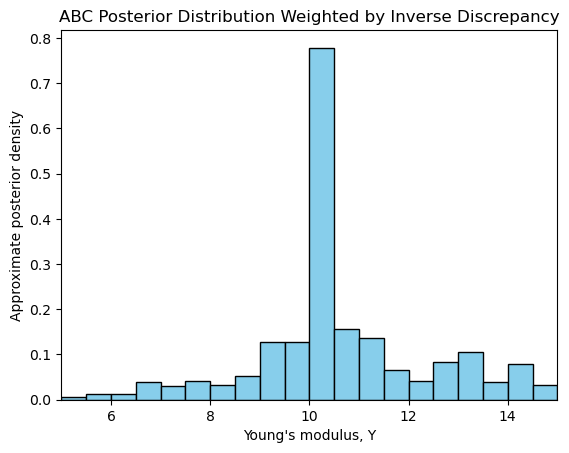

In [109]:
# Plot a weighted histogram of the samples
plt.hist(all_samples, bins=20, density=True, weights=all_weights_norm,
         range=(Y_min, Y_max), color="skyblue", edgecolor="black")
plt.xlabel("Young's modulus, Y")
plt.ylabel("Approximate posterior density")
plt.title("ABC Posterior Distribution Weighted by Inverse Discrepancy")
plt.xlim(Y_min, Y_max)  # Force x-axis to always span from Y_min to Y_max
plt.show()